# Figure 4G
Backpropgating a decision boundary and computing its curvature.

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import os, sys
from tqdm import tqdm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'

# Add cornet and Theano to path
sys.path.insert(0, '../')
sys.path.insert(0, '/home/poole/Theano_clean')

# Output figure directory
figure_dir = "../writeup/figures"
results_dir = "../results"
if not os.path.exists(figure_dir):
    raise ValueError("Figure directory does not exist. Create it or change figure_dir above.")
if not os.path.exists(results_dir):
    raise ValueError("Results directory does not exist. Create it or change results_dir above.")

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [4]:
n_hidden_layers = 10
n_hidden_units = 200
din = n_hidden_units
nonlinearity = 'tanh'
nonlinearity_str = nonlinearity

TODO: document decision boundary backprop code

In [10]:
from cornet.net import RandNet
net = RandNet(din, n_hidden_units, n_hidden_layers, nonlinearity=nonlinearity)
trained = False

In [13]:
import keras.backend as K
x_opt = K.variable(np.random.randn(din), name='x_opt')
output = net.model(x_opt.reshape((1, -1)))
w = np.random.randn(n_hidden_units)
w = w / np.linalg.norm(w)
w = K.variable(w)

In [14]:
if trained:
    w2 = np.zeros(net.output_dim)
    w2[pos_class] = 1
    w2[neg_class] = -1
else:
    w2 = np.random.randn(net.output_dim)
w2 /= np.linalg.norm(w2)
w.set_value(w2.astype(np.float32))

In [17]:
from cornet.constants import weight_sigmas, bias_sigmas, widxs, bidxs
weight_sigma = weight_sigmas[widxs[-1]]
bias_sigma = bias_sigmas[bidxs[-1]]
print(weight_sigma, bias_sigma)

4.0 0.3


In [18]:
if not trained:
    net.randomize(bias_sigma=bias_sigma, weight_sigma=weight_sigma)

In [19]:
from keras.models import Model
model_with_acts = Model(input=[net.model.input], output=[net.model.output, net.model.input] + net.hs)

In [20]:
outputs = model_with_acts(x_opt.reshape((1, -1)))
output, hs = outputs[0], outputs[1:]

In [21]:
G = K.sum(K.dot(output.reshape((-1,)), w))
loss = G**2

In [24]:
import theano
import theano.tensor as T
gs = [theano.gradient.grad(G, h) for h in  hs]
updates = []
Hs = []
for h, g in zip(hs, gs):
    H, ups = theano.scan(lambda i, gy, x: T.grad(gy[0,i], x), sequences=T.arange(g.shape[1]), non_sequences=[g, h] ) 
    Hs.append(H)
    updates.extend(ups)

In [25]:
%%time
f_grad_hess = theano.function(inputs=[], outputs=gs + Hs, updates=updates)

CPU times: user 17.3 s, sys: 380 ms, total: 17.7 s
Wall time: 17.7 s


In [27]:
from keras.optimizers import Adam
opt = Adam(lr=1e-3, beta_1=0.8)
updates = opt.get_updates([x_opt], [], loss)
start_state = opt.get_state()
f_train = theano.function(inputs=[], outputs=[loss], updates=updates)

In [28]:
def find_x(max_iter=250, sigma=1.0, qmax=30, x0=None):
    opt.set_state(start_state)
    if x0 is None:
        x0 = np.random.uniform(0, qmax) * sigma * 1.0/np.sqrt(din) * np.random.randn(din).astype(np.float32)
    x_opt.set_value(x0)
    for i in xrange(max_iter):
        loss = f_train()
    #print loss
    return loss[0], x_opt.get_value()

In [30]:
%%time
n_points = 10
xs = []

tol = 1e-9

while len(xs) < n_points:
    if trained:
        cidx = np.random.choice([pos_class, neg_class])
        didx = np.random.choice(np.flatnonzero(y_train==cidx))
        x0 = X_train[didx].ravel().astype(np.float32)
    else:
        x0 = None
    loss, x = find_x(x0=x0)
    print(len(xs), loss)
    if loss < tol:
        xs.append(x)
    
#xs = [find_x() for i in xrange(n_points)]

0 3.59726137766e-13
1 1.56519797123e-11
2 4.24036361579e-11
3 3.68718944266e-11
4 2.40163444687e-12
5 2.51799830986e-11
6 2.40163444687e-12
7 2.88569168561e-12
8 4.29878355135e-13
9 2.3492717105e-08
9 8.05805422388e-12
CPU times: user 2.15 s, sys: 336 ms, total: 2.48 s
Wall time: 2.48 s


In [31]:
#yscore = net.get_act(np.array(xs))
#yhat = np.argmax(yscore, axis=-1)
#print np.mean(yhat != y_test)
#plot(np.dot(yscore, w2)**2)

In [32]:
#for i in xrange(10):
#    imshow(xs[i].reshape(28, 28), interpolation='nearest'); grid('off'); show()

In [33]:
def compute_principal_curvatures(x):
    x_opt.set_value(x)
    gs_and_Hs = f_grad_hess()
    nlayer = len(gs_and_Hs)//2
    gs = gs_and_Hs[:nlayer]
    Hs = gs_and_Hs[nlayer:]
    out = []
    for lidx in xrange(nlayer):
        g, H = gs[lidx].squeeze(), Hs[lidx].squeeze()
        gnorm = np.linalg.norm(g)
        ghat = g / gnorm
        Hl = (H/gnorm - np.outer(ghat, np.dot(ghat, H/gnorm)))
        Hnormal = Hl - np.outer(np.dot(Hl, ghat), ghat)
        w, v = np.linalg.eig(Hnormal)
        out.append(np.real(np.sort(w)))
    return out

In [34]:
from tqdm import tqdm

In [55]:
pcs = []
for i, x in enumerate(tqdm(xs)):
    if trained:
        pcs.append(compute_principal_curvatures(x)[:])
    else:
        pcs.append(compute_principal_curvatures(x)[:])
        
tmp = zip(*pcs)
curvatures = [np.array(f) for f in tmp]
avg_curvatures = [c.mean(0) for c in curvatures]
std_curvatures = [c.std(0) for c in curvatures]

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


# Figure 4G:
(G) average principal curvatures for the largest and smallest 4 principal curvatures (κ ± 1, ..., κ ± 4) across locations θ within one network. The principal curvatures all grow exponentially as we backpropagate to the input layer. Panels F,G are discussed in Sec. 5.

In [39]:
nkappa = 4

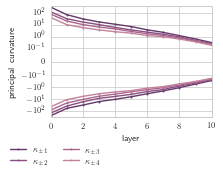

In [65]:
figure(figsize=(3, 2))
gs = GridSpec(1, 1)

pal = sns.cubehelix_palette(nkappa+ 3, reverse=True, light=0.9)[:nkappa]
sns.set_palette(pal) 

subplot(gs[0, 0])
pal = sns.cubehelix_palette(nkappa + 3, reverse=True, light=0.9, dark=0.3)[:nkappa]
xx = np.arange(len(curvatures))
for k in xrange(nkappa):
    kpos = [ac[-(k+1)] for ac in avg_curvatures]
    kneg = [ac[k] for ac in avg_curvatures]
    plot(xx, kpos, 'o-', color=pal[k], markersize=2)
    plot(xx, kneg, 'o-', color=pal[k], markersize=2, label='_nolegend_')
    
gca().set_yscale('symlog', linthreshy=linthreshy)
ylim(-ymax, ymax)
legend([r'$\kappa_{\pm%d}$'%d for d in np.arange(1, nkappa+1)], ncol=2, bbox_to_anchor=(0.35, -0.2))
gcf().tight_layout()
xlabel('layer')
ylabel(r'principal curvature')

savefig(os.path.join(figure_dir, "fig4f_boundary.pdf" ), bbox_inches='tight')

## Supp spectrum plot

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def plot_spectrum(layer=2, nline=25, xmax=6, ymax=1000, pal=pal, borderpad=0.1, linthreshy=1e-6):
    idx = [layer]
    csort = [np.sort(c, axis=-1) for c in curvatures]
    handles = []
    nunit = csort[idx[0]][:nline].shape[-1]
    ax = gca()
    for j, lidx in enumerate(idx):
        h = plot(csort[lidx][:nline].T, c=pal[lidx])
        handles.append(h[0])
    ylim(-ymax, ymax)
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(ax,
                        width="40%", 
                        height="40%",
                        loc=2, borderpad=borderpad)

    for j, lidx in enumerate(idx):
        axins.plot(csort[lidx][:nline].T, '-', c=pal[lidx], zorder=0)
        for ll in xrange(nline):
            axins.scatter(np.arange(nkappa), csort[lidx][ll, :nkappa], marker='o',s=8, c=pal_kappa)

    axins.set_yscale('symlog', linthreshy=linthreshy)
    axins.set_xlim(-.5, xmax)
    axins.set_ylim(-ymax, 0)
    axins.set_xticks([]); axins.set_yticks([])
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    axins = inset_axes(ax,
                        width="40%",  # width = 10% of parent_bbox width
                        height="40%",  # height : 50%
                        loc=4, borderpad=borderpad)

    for j, lidx in enumerate(idx):
        axins.plot(csort[lidx][:nline].T, '-', c=pal[lidx], zorder=0)
        for ll in xrange(nline):
            axins.scatter(nunit-1-np.arange(nkappa), csort[lidx][ll, -nkappa:][::-1], marker='o',s=8, c=pal_kappa)
    axins.set_yscale('symlog', linthreshy=linthreshy)
    axins.set_ylim(0, ymax)
    axins.set_xlim(nunit-xmax-1, nunit-.5)
    axins.set_xticks([]); axins.set_yticks([])


    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    
    ax.set_xlabel('sorted eigenvalue index')
    ax.set_ylabel('eigenvalue')
    ax.set_yscale('symlog', linthreshy=linthreshy)


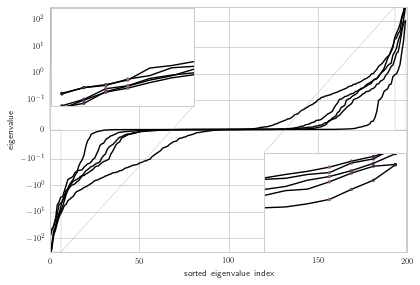

In [63]:
linthreshy = 1e-1
ymax = np.max([np.abs(ac).max() for ac in curvatures])/2.
pal_kappa = pal
plot_spectrum(layer=0, nline=5, ymax=ymax, pal=[[0,0,0,1]]*100, linthreshy=linthreshy)